# **Introduction**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

data = np.load('DataFeatSel.npy', allow_pickle = True).item()

In [ ]:
X_train = list(data.values())[0]
Y_train = list(data.values())[1]
Y_test = list(data.values())[2]
X_test = list(data.values())[3]

# **Exercise 14**

In [ ]:
def CrossValidationLS(X, Y, features):
    ''' 
    function to conduct five-fold cross validation using least squares &
    only the selected features

    X, Y: training data
    features: indices indicating the features under consideration

    final_loss: average loss across all folds
    '''

    n = X.shape[0]
    ind_fold = n/5
    loss = []

    X = X[:, features]
    
    for i in range(1,6): # 5-fold cross validation
      loss_fold = 0

      ind_val = np.arange((i-1)*ind_fold, i*ind_fold).astype(int)
      ind_train = np.array([ind for ind in range(n) if ind not in ind_val]).astype(int)

      Xval, Xtrain = X[ind_val], X[ind_train]
      Yval, Ytrain = Y[ind_val], Y[ind_train]

      # compute w
      w = np.linalg.solve(Xtrain.T@Xtrain, Xtrain.T@Ytrain)

      loss_fold = 1/2*np.absolute(Yval-np.sign(Xval@w))
      loss.append(np.sum(loss_fold))

    final_loss = np.sum(loss) / n
    return final_loss

In [ ]:
def powerset(s):
    ''' 
    function to compute all subsets of the set s
    '''

    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1, 1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

In [ ]:
# use cross-validation to determine best feature subset among all of them

subsets = list(powerset(list(range(X_train.shape[1])))) # construct all subsets
CVErrors = np.zeros([len(subsets), 1])

for i in tqdm(range(len(subsets))):
  CVErrors[i] = CrossValidationLS(X_train, Y_train, subsets[i])

100%|██████████| 32767/32767 [01:05<00:00, 497.05it/s]


In [ ]:
# report lowest error and best subset as well as error on test set if only
# include those features

best_subsets = np.where(CVErrors == min(CVErrors))

for i in range(len(best_subsets[0])):
  best_subset = subsets[best_subsets[0][i]]
  print('Best feature subset:', best_subset, 'with CV error:', CVErrors[best_subsets[0][i]])

  X_train_subset = X_train[:, best_subset]
  w_subset = np.linalg.solve(X_train_subset.T@X_train_subset, X_train_subset.T@Y_train)

  # evaluate the performance of the classifier(s)
  X_test_subset = X_test[:, best_subset]
  loss_test = 1/2*np.absolute(Y_test-np.sign(X_test_subset@w_subset))
  print('Error on test set:', np.sum(loss_test)/X_test_subset.shape[0], '\n')

Best feature subset: [3, 8, 9] with CV error: [0.2]
Error on test set: 0.497 

Best feature subset: [3, 9, 10] with CV error: [0.2]
Error on test set: 0.502 

Best feature subset: [3, 9, 10, 11] with CV error: [0.2]
Error on test set: 0.504 

Best feature subset: [3, 8, 9, 10, 13] with CV error: [0.2]
Error on test set: 0.504 

Best feature subset: [3, 4, 8, 9, 11, 13] with CV error: [0.2]
Error on test set: 0.478 



**Do you have an idea why the cross-validation error obtained in a) and the just computed test error are so different? Does this have to do with the classifier or the feature selection ? What will you tell the biologists ?**

The test errors are significantly higher than the cross-validation errors obtained in a) for all of the best feature subsets. This is probably because of the feature selection and not because of the classifier as the best subsets were only the best ones for the training data but not for the problem at hand. Hence, overfitting took place as the selected features work well for the training data, but do not generalize to unseen data (test data). 
This is the also the case because we have a small training set (40 observations) in contrast to a large test set (1000 observations).

Accordingly, one should tell the biologists that using only the smallest best subset without verifying its accuracy on an independent dataset is a bad idea and they should pursue this subset approach.

# **Exercise 15**

In [ ]:
subsets = list(powerset(list(range(6)))) # construct subsets for first 6 features
CVErrors = np.zeros([len(subsets), 1])

# determine original test statistic
for i in tqdm(range(len(subsets))):
  CVErrors[i] = CrossValidationLS(X_train, Y_train, subsets[i])

t = np.min(CVErrors)

100%|██████████| 63/63 [00:00<00:00, 884.86it/s]


In [ ]:
# compute test statistics for permuted labels

test_statistics = []
np.random.seed(1)
for i in tqdm(range(1000)):
  CVErrors = np.zeros([len(subsets), 1])
  Y_train_permut = np.random.permutation(Y_train)

  for i in range(len(subsets)):
    CVErrors[i] = CrossValidationLS(X_train, Y_train_permut, subsets[i])

  test_statistics.append(np.min(CVErrors))

100%|██████████| 1000/1000 [01:12<00:00, 13.78it/s]


Rejection region = (-∞, 0.25]
Original test statistic = 0.325
Approximate p-value = 0.303 



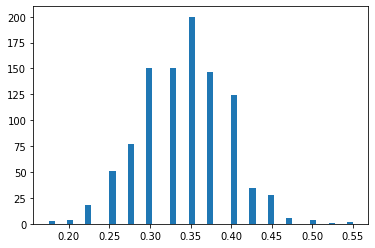

In [ ]:
plt.hist(test_statistics, 50);

print("Rejection region = (-∞, {}]".format(np.around(np.quantile(test_statistics, 0.05), 2)))
print("Original test statistic = {}".format(t))
print("Approximate p-value = {} \n".format(np.around((test_statistics < t).sum()/len(test_statistics), 4)))

**What cross-validation error do you expect under the null hypothesis ?**

Under the null hypothesis that features & labels are independent, a cross-validation error of 0.5 is expected. 

**Decision (reject/not reject the null hypothesis) *(written on paper)*. What does the result of the test imply for the result obtained in 14a) ?**

Based on the p-value of 0.303 and the fact that the original test statistic lies not in the rejection region, the null hypothesis of independence between features and labels cannot be rejected. This goes hand in hand with the previously obtained result that the test error exceeds the CV error by far. The low CV errors might be due to fitting the idiosyncrasies of the training data, but not because of identifying a true relationship. Since the true relationship is not captured and might not even be able to be captured (because of the potential independence of X and Y), the test error is close to 0.5. The latter is as good as a random guess is expected to perform. Once again, it makes only  sense to train classifiers where inputs and outputs are related, which is not supported by the permutation test.